https://medium.com/@rasmushaa/how-to-model-options-using-partial-differential-equations-and-ito-calculus-ae1576fb138a

In [1]:
import numpy as np
import jax.numpy as jnp
import jax.random as jrandom
import jax.scipy as jscipy
from matplotlib import pyplot as plt
import matplotlib.collections as mcoll
from time import time
import math

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams.update({'font.size': 14})
CMAP = plt.get_cmap('copper')

In [2]:
def mc_stock_price(S0:float, T:float, r:float, sigma:float, samples=1000):
    """ Computes estimated stock price at maturity

    Parameters
    ----------
    S0 : float
        Initial price of the underlying
    T : float
        Time to maturity of the option in years
    r : float
        Risk-free return rate 
    sigma : float
        Historical yearly volatility, assuming 255 trading days
    samples : int
        Number of simulations

    Returns
    -------
    S : array
        Contains N amount of possible prices
    """
    n = 255*T       #Convert years into days
    dt = T/n
    S = jnp.ones([n, samples])*S0
    random_step = jrandom.normal(jrandom.PRNGKey(1), shape=[n-1, samples])
    for i in range(1, n):
        S = S.at[i, :].set(S[i-1, :] * (1 + r*dt + sigma*jnp.sqrt(dt) * random_step[i-1, :]))
    return S

In [3]:
def model_stock_price(S0:float, T:float, r:float, sigma:float, samples=1000):
    """ Computes estimated stock prica at maturity

    Parameters
    ----------
    S0 : float
        Initial price of the underlying
    T : float
        Time to maturity of the option in years
    r : float
        Risk-free return rate 
    sigma : float
        Historical yearly volatility, assuming 255 trading days
    samples : int
        Number of simulations

    Returns
    -------
    S : array
        Contains N amount of possible prices
    """
    random_step  = jrandom.normal(jrandom.PRNGKey(1), shape=[samples, 1])
    S = jnp.ones(samples)*S0
    S = S*jnp.exp(T*(r - 0.5*sigma**2) + sigma*jnp.sqrt(T)*random_step)
    return S

In [4]:
def mc_call_option_price(S0:float, E:float, T:float, r:float, sigma:float, samples:int=1000)->jnp.array:
    """ Computes PV of one Call option, using the Risk-Neutral Approach

    Parameters
    ----------
    S0 : float
        Initial price of the underlying
    E : float
        The strike price of the option
    T : float
        Time to maturity of the option in years
    r : float
        Risk-free return rate 
    sigma : float
        Historical yearly volatility, assuming 255 trading days
    samples : int
        Number of simulations

    Returns
    -------
    mean : float
        Mean call value of all simulations
    option_price_dist : array
        A JAX Numpy array of value distribution (assuming excecution of all calls)
    """
    random_step  = jrandom.normal(jrandom.PRNGKey(1), shape=[samples])
    S = jnp.ones(samples)*S0
    E = jnp.ones(samples)*E
    S = S*jnp.exp(T*(r - 0.5*sigma**2) + sigma*jnp.sqrt(T)*random_step)
    # Option is excecuted only if it's positive
    option_price_dist = jnp.zeros([samples, 2])
    option_price_dist = option_price_dist.at[:, 0].set(S-E)
    option_price = jnp.max(option_price_dist, axis=1)
    # Discounted price
    option_price = jnp.exp(-r*T)*option_price
    option_price_dist = jnp.exp(-r*T)*option_price_dist
    # Mean of uniform probability distribution is the average
    mean = jnp.sum(option_price)/samples
    return mean, option_price_dist[:, 0]

In [5]:
def bs_call_option_price(S0:float, E:float, T:float, r:float, sigma:float, samples=1000):
    """ Computes PV of one Call option, using Black-Scholes formula

    Parameters
    ----------
    S0 : float
        Initial price of the underlying
    E : float
        The strike price of the option
    T : float
        Time to maturity of the option in years
    r : float
        Risk-free return rate 
    sigma : float
        Historical yearly volatility, assuming 255 trading days
    samples : int
        Number of simulations

    Returns
    -------
    price : float
        Analutical solution for the price
    """

    d1 = (jnp.log(S0/E) + (r + sigma**2/2)*T) / (sigma*jnp.sqrt(T))
    d2 = d1 - sigma*jnp.sqrt(T)
    price = S0*jscipy.stats.norm.cdf(d1, 0, 1) - E*jnp.exp(-r*T)*jscipy.stats.norm.cdf(d2, 0, 1) 
    return price

In [6]:
def get_line_collection(x:np.array, y:np.array, cmap:plt.colormaps=plt.get_cmap('copper'), alpha_min=0.02):

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    z = np.linspace(0.0, 1.0, len(x))
    alphas = np.linspace(alpha_min, 1, len(x))
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, linewidths=(0.8), norm=plt.Normalize(0.0, 1.0), alpha=alphas)

    return lc

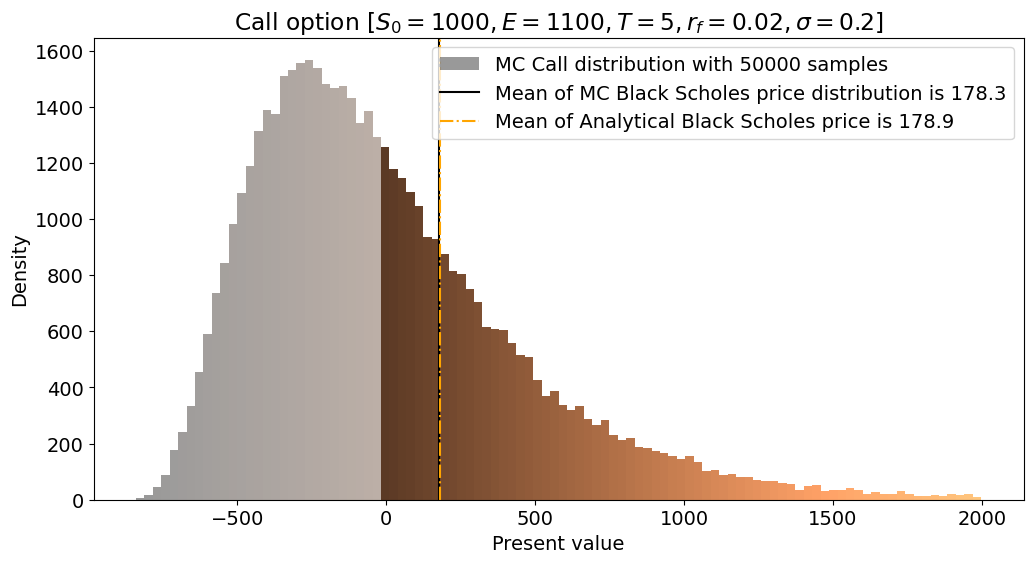

In [7]:
S0      = 1000
E       = 1100
T       = 5
r       = 0.02
sigma   = 0.2
N       = 50000

mean, dist = mc_call_option_price(S0, E, T, r, sigma, samples=N)
dist = dist[dist < 2*S0]
price = bs_call_option_price(S0, E, T, r, sigma, samples=N)
analytical_mean = price

plt.figure('Call Option pricing')
plt.clf()
# Histogram
n, bins, patches = plt.hist(dist, bins=100, alpha=1, label=f'MC Call distribution with {N} samples')
z = np.linspace(0.0, 1.0, len(bins))
for p, c in zip(patches, z):
    plt.setp(p, 'facecolor', CMAP(c))
for i in range(0, len(bins[bins<=0]) -1):
    patches[i].set_alpha(0.4)
# Mean lines
plt.axvline(x=mean, c='black', ls='-', label=f'Mean of MC Black Scholes price distribution is {mean:.1f}')
plt.axvline(x=analytical_mean, c='orange', ls='-.', label=f'Mean of Analytical Black Scholes price is {analytical_mean:.1f}')

plt.legend()
plt.ylabel('Density')
plt.xlabel('Present value')
plt.title(f'Call option [$S_0={S0}, E={E}, T={T}, r_f={r}, \sigma={sigma}$]')
plt.show()

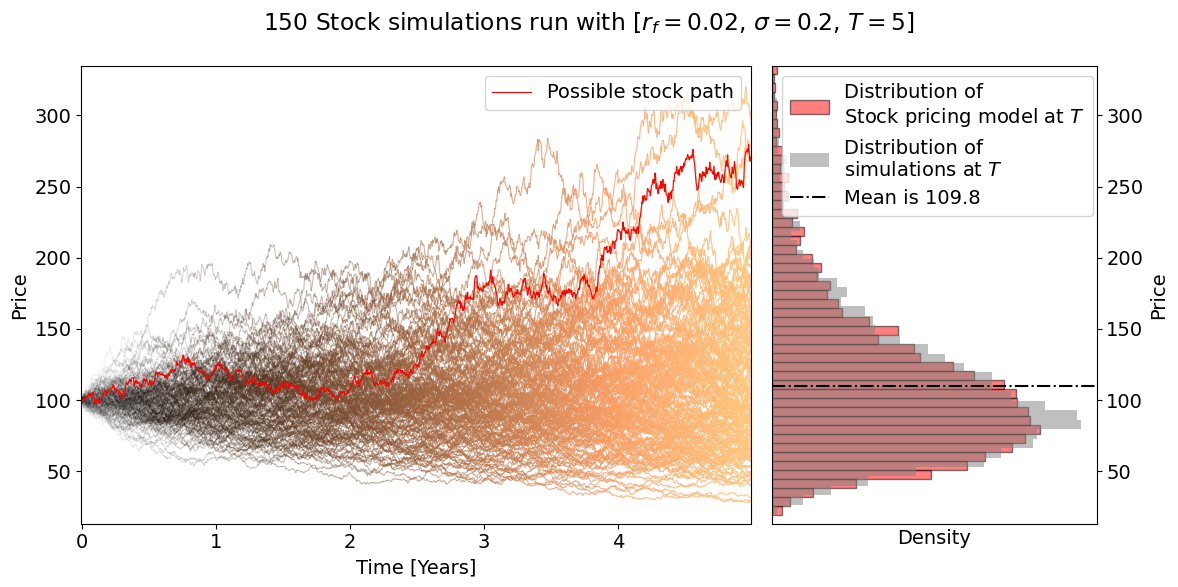

In [8]:
S0      = 100
T       = 5
r       = 0.02
sigma   = 0.2

plt.figure('Stock price process')
plt.clf()

# Stock simulations
left = plt.subplot2grid((1, 3), (0, 0), rowspan=1, colspan=2)
S = mc_stock_price(S0, T, r, sigma, 150)
for i in range(len(S[0])):
    x = np.linspace(0, len(S), len(S))
    lc = get_line_collection(x, S[:,i])
    plt.gca().add_collection(lc)
left.plot(S[:, 0], c='r', lw=0.8, label='Possible stock path')
ticks = np.arange(1, len(S[:,0]), 255)
plt.xticks(ticks, np.arange(0, T, 1))
plt.margins(x=0)
plt.ylabel('Price')
plt.xlabel('Time [Years]')
plt.legend()

# Stock model prices
right = plt.subplot2grid((1, 3), (0, 2), rowspan=1, colspan=1)
S = mc_stock_price(S0, T, r, sigma, 5000)
s = model_stock_price(S0, T, r, sigma, 5000)
right.hist(s[:,0], bins=70, color='r', alpha=0.5, ec='black', orientation="horizontal", label='Distribution of\nStock pricing model at $T$')
right.hist(S[-1,:], bins=70, color='grey', alpha=0.5, orientation="horizontal", label='Distribution of\nsimulations at $T$')
mean = np.mean(S[-1,:])
plt.axhline(y=mean, c='black', ls='-.', label=f'Mean is {mean:.1f}')

plt.setp(plt.gca(), ylim=left.get_ylim())
plt.ylabel('Price')
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")
plt.gca().set_xticks([])
plt.xlabel('Density')
plt.legend()

plt.subplots_adjust(wspace=0)
plt.gcf().suptitle(f'150 Stock simulations run with [$r_f={r}$, $\sigma={sigma}$, $T={T}$]')
plt.tight_layout()
plt.show()